# Link Google Colab
[Google Colab](https://colab.research.google.com/drive/14AOyW57lt1AJpziNTRmvgRo8x3aXCPpQ?usp=sharing)

# Referensi
- https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-quick-start.html
- https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-indepth.html

## Install and Import Library

In [ ]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requiremen

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from datetime import datetime
import pytz

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

## Load Data

In [ ]:
!wget https://github.com/hilmizr/world_fertilizer_price/raw/master/01-09-24-modified_fertilizer_datav5.xlsx

--2024-09-04 22:23:26--  https://github.com/hilmizr/world_fertilizer_price/raw/master/01-09-24-modified_fertilizer_datav5.xlsx
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hilmizr/world_fertilizer_price/master/01-09-24-modified_fertilizer_datav5.xlsx [following]
--2024-09-04 22:23:26--  https://raw.githubusercontent.com/hilmizr/world_fertilizer_price/master/01-09-24-modified_fertilizer_datav5.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42737 (42K) [application/octet-stream]
Saving to: ‘01-09-24-modified_fertilizer_datav5.xlsx.1’

01-09-24-modified_f 100%[===================>]  41.74K

In [ ]:
date_col = 'date'
target_col = 'urea_price'

In [ ]:
data = pd.read_excel('01-09-24-modified_fertilizer_datav5.xlsx')
data

,date,dap_price,kcl_price,rock_price,tsp_price,urea_price
0,1993-11-01,140.40,112.50,31.5,112.50,82.80
1,1993-12-01,150.38,112.50,31.5,122.50,85.50
2,1994-01-01,150.00,112.50,31.5,125.00,85.50
3,1994-02-01,151.75,112.50,31.5,125.63,85.50
4,1994-03-01,155.88,112.50,31.5,127.50,98.63
...,...,...,...,...,...,...
361,2023-12-01,563.75,311.88,152.5,447.50,354.00
362,2024-01-01,596.25,296.25,152.5,450.63,335.38
363,2024-02-01,583.81,289.38,152.5,454.38,351.25
364,2024-03-01,617.50,300.50,152.5,449.00,330.00


# Data Preparation

## Format Data

In [ ]:
data[date_col] = pd.to_datetime(data[date_col])
data.set_index(date_col, inplace=True)
data = data.asfreq('MS')

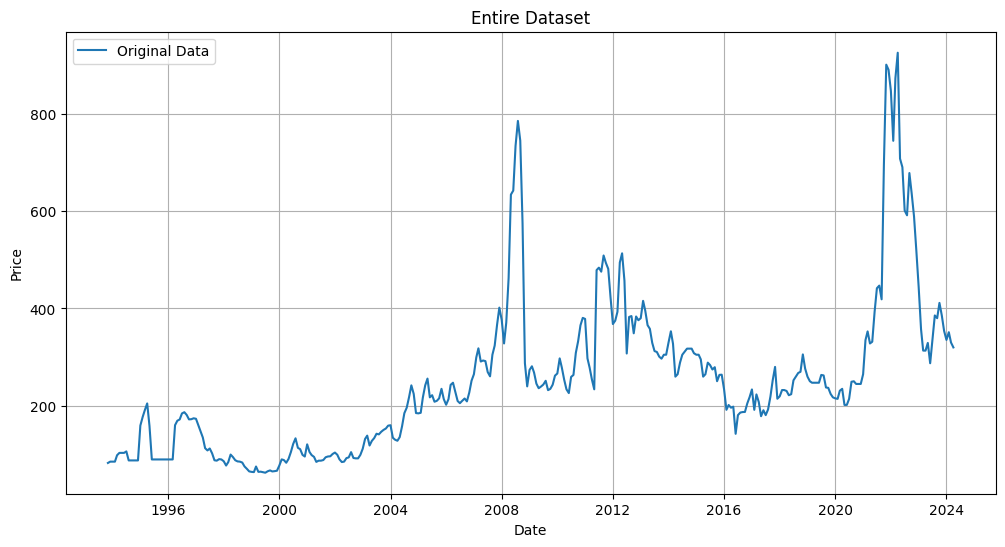

In [ ]:
# Plot the entire dataset
plt.figure(figsize=(12, 6))
plt.plot(data.index, data[target_col], label='Original Data')
plt.title('Entire Dataset')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Detect and Interpolate Null and Zero Values

In [ ]:
data[target_col] = data[target_col].replace(0, np.nan)
if data[target_col].isnull().any():
  data[target_col] = data[target_col].interpolate(method='linear')
  data[target_col] = data[target_col].fillna(method='ffill').fillna(method='bfill')

## Reformat to AutoGluon

In [ ]:
data = data.reset_index()

In [ ]:
temp = pd.DataFrame({
    'item_id': target_col,
    'timestamp': data[date_col],
    'target': data[target_col].values
})
temp

,item_id,timestamp,target
0,urea_price,1993-11-01,82.80
1,urea_price,1993-12-01,85.50
2,urea_price,1994-01-01,85.50
3,urea_price,1994-02-01,85.50
4,urea_price,1994-03-01,98.63
...,...,...,...
361,urea_price,2023-12-01,354.00
362,urea_price,2024-01-01,335.38
363,urea_price,2024-02-01,351.25
364,urea_price,2024-03-01,330.00


In [ ]:
ag_data = TimeSeriesDataFrame.from_data_frame(
    temp,
    id_column="item_id",
    timestamp_column="timestamp"
)
ag_data.head()

target
item_id    timestamp         
urea_price 1993-11-01   82.80
           1993-12-01   85.50
           1994-01-01   85.50
           1994-02-01   85.50
           1994-03-01   98.63

In [ ]:
date_col = 'timestamp'
target_col = 'target'

## Train Test Split

In [ ]:
n_test = 6

In [ ]:
train_data, test_data = train_test_split(ag_data, test_size=n_test, shuffle=False)

In [ ]:
train_data

target
item_id    timestamp         
urea_price 1993-11-01   82.80
           1993-12-01   85.50
           1994-01-01   85.50
           1994-02-01   85.50
           1994-03-01   98.63
...                       ...
           2023-06-01  287.50
           2023-07-01  334.63
           2023-08-01  385.63
           2023-09-01  380.00
           2023-10-01  411.38

[360 rows x 1 columns]

In [ ]:
test_data

target
item_id    timestamp         
urea_price 2023-11-01  385.50
           2023-12-01  354.00
           2024-01-01  335.38
           2024-02-01  351.25
           2024-03-01  330.00
           2024-04-01  320.00

# Modeling - Fast Training

## Define Predictor

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=n_test,
    path="autogluon",
    target="target",
    eval_metric="MASE",
)

## Fit Predictor

In [ ]:
predictor.fit(
    train_data,
    presets="fast_training",
    time_limit=600,
    num_val_windows=3
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          8
GPU Count:          0
Memory Avail:       48.89 GB / 50.99 GB (95.9%)
Disk Space Avail:   183.52 GB / 225.83 GB (81.3%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'very_light',
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 360 rows, 1 time series.

## Predict

In [ ]:
predictions = predictor.predict(train_data)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id    timestamp                                                    
urea_price 2023-11-01  343.225760  289.717657  307.987460  321.168662   
           2023-12-01  336.566479  260.847840  286.808568  305.542111   
           2024-01-01  342.654411  249.481168  281.443257  304.383547   
           2024-02-01  371.012740  264.015976  300.511242  327.268375   
           2024-03-01  373.627378  253.284115  294.411983  324.331220   
           2024-04-01  368.037455  235.306895  280.562684  313.473235   

                              0.4         0.5         0.6         0.7  \
item_id    timestamp                                                    
urea_price 2023-11-01  332.601625  343.225760  353.877245  365.201361   
           2023-12-01  321.584285  336.566479  351.490213  367.589582   
           2024-01-01  324.254601  342.654411  361.214229  380.910648   
           2024-02-01  349.871538  371.012740  392.479915  415.465049   
           2024-03-01  349.797861  373.627378  397.571192  423.276152   
           2024-04-01  341.529912  368.037455  394.142303  422.121793   

                              0.8         0.9  
item_id    timestamp                           
urea_price 2023-11-01  378.433396  396.932571  
           2023-12-01  386.431501  412.549218  
           2024-01-01  404.013885  435.994169  
           2024-02-01  442.021175  478.816965  
           2024-03-01  452.999241  494.734509  
           2024-04-01  454.793849  500.700523

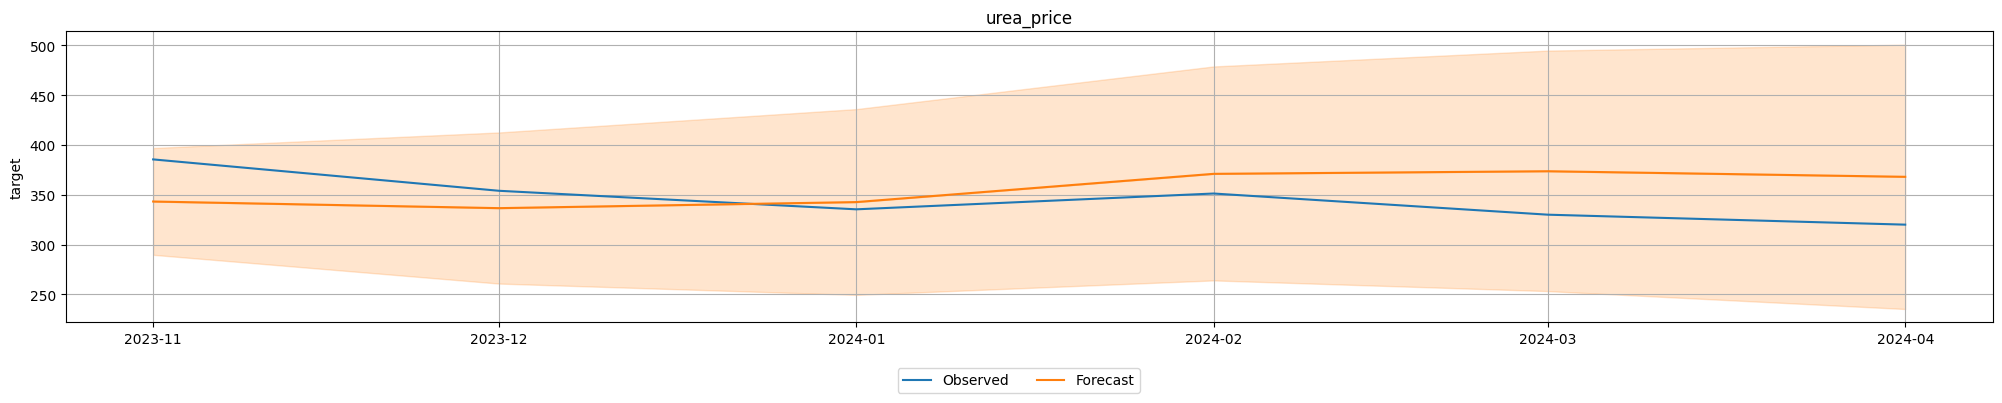

In [ ]:
# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=300, max_num_item_ids=1);

## Compare

In [ ]:
actual = test_data[target_col].values
pred = predictions['mean'].values.flatten()

In [ ]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index.get_level_values('timestamp')
comparison_df

,Actual,Predicted
timestamp,,
2023-11-01,385.50,343.225760
2023-12-01,354.00,336.566479
2024-01-01,335.38,342.654411
2024-02-01,351.25,371.012740
2024-03-01,330.00,373.627378
2024-04-01,320.00,368.037455


## Evaluate

In [ ]:
def evaluate_forecast(y_true, y_pred):
    results = {
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }
    return pd.Series(results)

In [ ]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.086531
RMSE,33.529756
MAE,29.734957
R2,-1.501477


## Recap

In [ ]:
evaluation_summary = pd.DataFrame(columns=['Preset'])

In [ ]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Preset'] = 'fast_training'
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Preset,MAPE,RMSE,MAE,R2
0,fast_training,0.086531,33.529756,29.734957,-1.501477


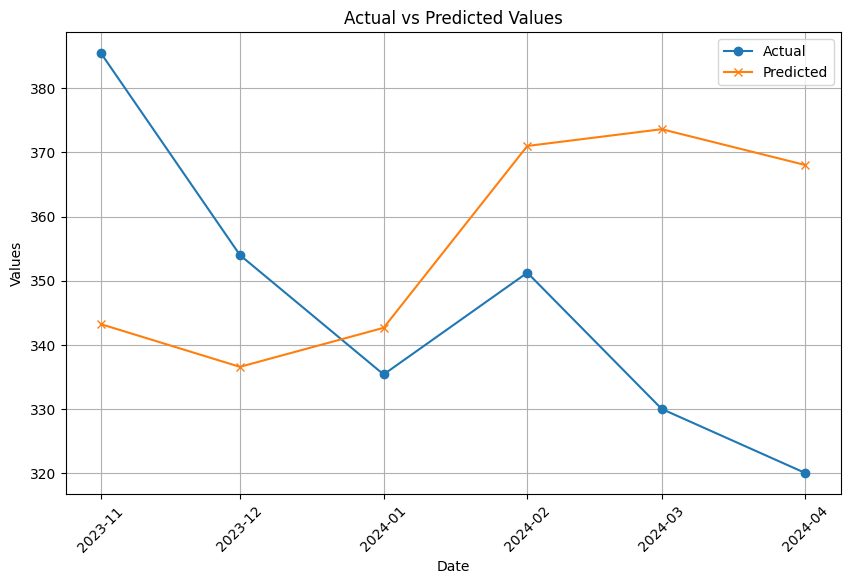

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Modeling - Medium Quality

## Define Predictor

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=n_test,
    path="autogluon",
    target="target",
    eval_metric="MASE",
)

## Fit Predictor

In [ ]:
predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
    num_val_windows=3
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          8
GPU Count:          0
Memory Avail:       47.77 GB / 50.99 GB (93.7%)
Disk Space Avail:   183.52 GB / 225.83 GB (81.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 360 rows, 1 time series. Med

## Predict

In [ ]:
predictions = predictor.predict(train_data)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id    timestamp                                                    
urea_price 2023-11-01  343.225760  289.717657  307.987460  321.168662   
           2023-12-01  336.566479  260.847840  286.808568  305.542111   
           2024-01-01  342.654411  249.481168  281.443257  304.383547   
           2024-02-01  371.012740  264.015976  300.511242  327.268375   
           2024-03-01  373.627378  253.284115  294.411983  324.331220   
           2024-04-01  368.037455  235.306895  280.562684  313.473235   

                              0.4         0.5         0.6         0.7  \
item_id    timestamp                                                    
urea_price 2023-11-01  332.601625  343.225760  353.877245  365.201361   
           2023-12-01  321.584285  336.566479  351.490213  367.589582   
           2024-01-01  324.254601  342.654411  361.214229  380.910648   
           2024-02-01  349.871538  371.012740  392.479915  415.465049   
           2024-03-01  349.797861  373.627378  397.571192  423.276152   
           2024-04-01  341.529912  368.037455  394.142303  422.121793   

                              0.8         0.9  
item_id    timestamp                           
urea_price 2023-11-01  378.433396  396.932571  
           2023-12-01  386.431501  412.549218  
           2024-01-01  404.013885  435.994169  
           2024-02-01  442.021175  478.816965  
           2024-03-01  452.999241  494.734509  
           2024-04-01  454.793849  500.700523

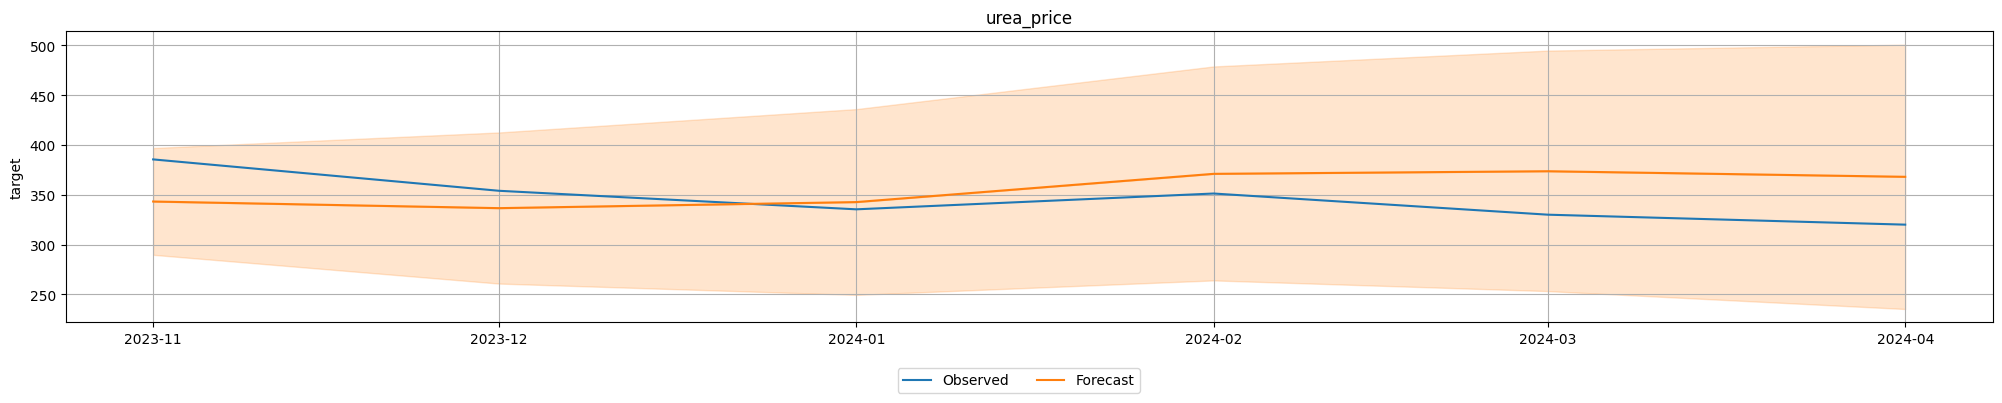

In [ ]:
# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=300, max_num_item_ids=1);

## Compare

In [ ]:
actual = test_data[target_col].values
pred = predictions['mean'].values.flatten()

In [ ]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index.get_level_values('timestamp')
comparison_df

,Actual,Predicted
timestamp,,
2023-11-01,385.50,343.225760
2023-12-01,354.00,336.566479
2024-01-01,335.38,342.654411
2024-02-01,351.25,371.012740
2024-03-01,330.00,373.627378
2024-04-01,320.00,368.037455


## Evaluate

In [ ]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.086531
RMSE,33.529756
MAE,29.734957
R2,-1.501477


## Recap

In [ ]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Preset'] = 'medium_quality'
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Preset,MAPE,RMSE,MAE,R2
0,fast_training,0.086531,33.529756,29.734957,-1.501477
1,medium_quality,0.086531,33.529756,29.734957,-1.501477


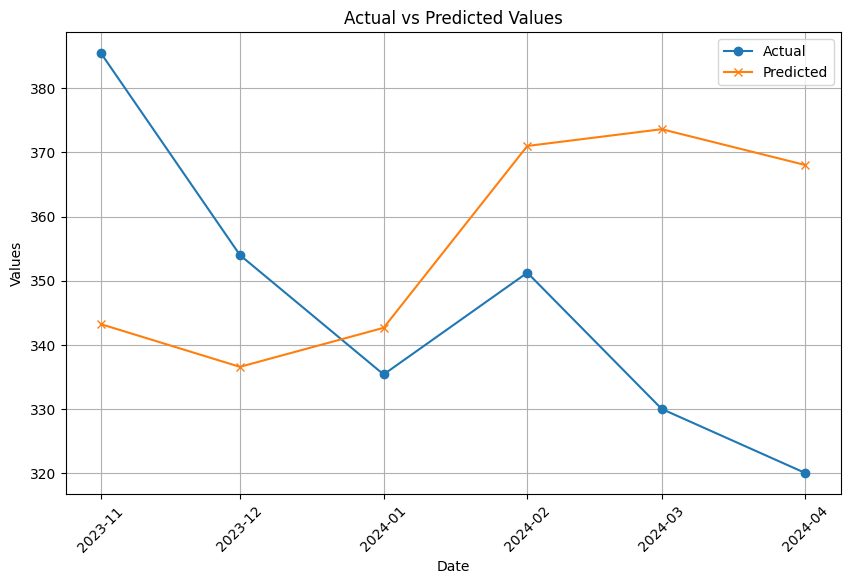

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Modeling - High Quality

## Define Predictor

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=n_test,
    path="autogluon",
    target="target",
    eval_metric="MASE",
)

## Fit Predictor

In [ ]:
predictor.fit(
    train_data,
    presets="high_quality",
    time_limit=600,
    num_val_windows=3
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          8
GPU Count:          0
Memory Avail:       47.71 GB / 50.99 GB (93.6%)
Disk Space Avail:   183.52 GB / 225.83 GB (81.3%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 360 rows, 1 time series. Med

## Predict

In [ ]:
predictions = predictor.predict(train_data)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id    timestamp                                                    
urea_price 2023-11-01  385.334921  310.044520  337.657598  355.827777   
           2023-12-01  367.640506  262.190878  299.341826  323.868054   
           2024-01-01  363.184072  234.910582  280.918742  311.679682   
           2024-02-01  362.919308  217.352911  268.277599  304.281720   
           2024-03-01  356.801668  197.180142  253.658924  292.500654   
           2024-04-01  357.438520  185.318959  246.055885  287.952080   

                              0.4         0.5         0.6         0.7  \
item_id    timestamp                                                    
urea_price 2023-11-01  370.766593  385.334921  399.827289  414.899438   
           2023-12-01  347.267361  367.640506  388.395066  409.961846   
           2024-01-01  337.866028  363.184072  387.901106  414.494522   
           2024-02-01  333.937982  362.919308  392.393159  422.544370   
           2024-03-01  325.610012  356.801668  388.263425  421.324702   
           2024-04-01  323.645659  357.438520  390.966128  426.452635   

                              0.8         0.9  
item_id    timestamp                           
urea_price 2023-11-01  432.843355  464.075177  
           2023-12-01  434.679994  475.017565  
           2024-01-01  445.681725  492.208225  
           2024-02-01  457.313743  509.605053  
           2024-03-01  459.727039  516.923756  
           2024-04-01  468.015902  529.806117

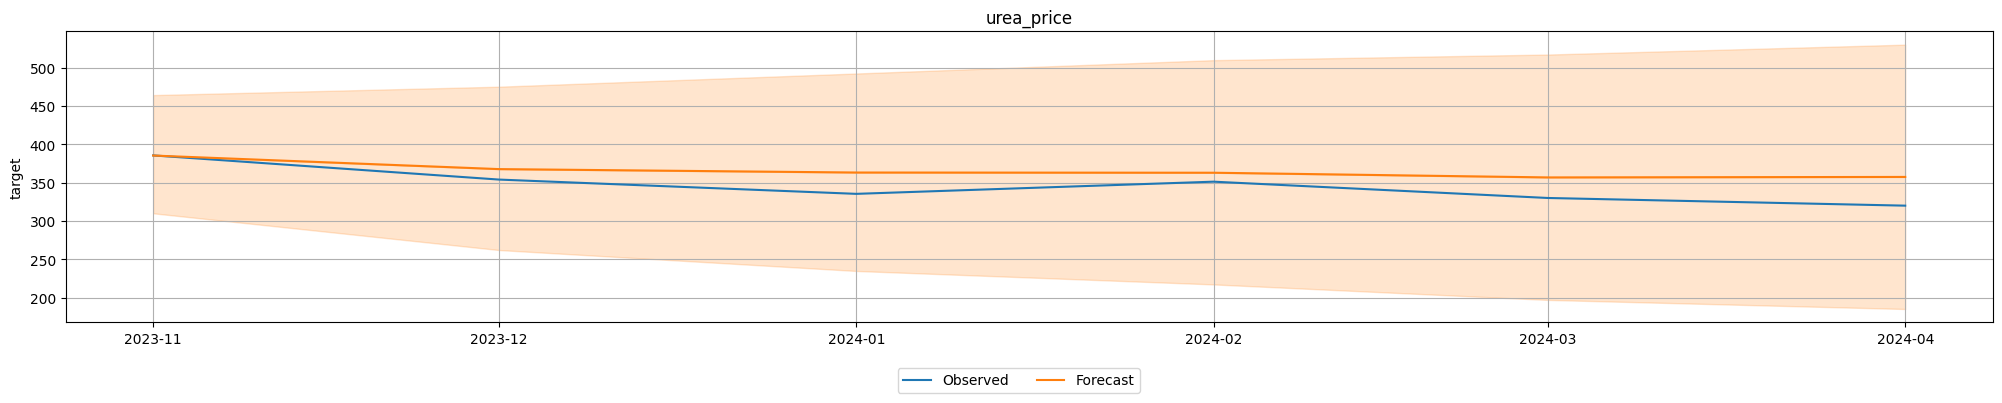

In [ ]:
# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=300, max_num_item_ids=1);

## Compare

In [ ]:
actual = test_data[target_col].values
pred = predictions['mean'].values.flatten()

In [ ]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index.get_level_values('timestamp')
comparison_df

,Actual,Predicted
timestamp,,
2023-11-01,385.50,385.334921
2023-12-01,354.00,367.640506
2024-01-01,335.38,363.184072
2024-02-01,351.25,362.919308
2024-03-01,330.00,356.801668
2024-04-01,320.00,357.438520


## Evaluate

In [ ]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.058883
RMSE,23.149161
MAE,19.586526
R2,-0.192357


## Recap

In [ ]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Preset'] = 'high_quality'
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Preset,MAPE,RMSE,MAE,R2
0,fast_training,0.086531,33.529756,29.734957,-1.501477
1,medium_quality,0.086531,33.529756,29.734957,-1.501477
2,high_quality,0.058883,23.149161,19.586526,-0.192357


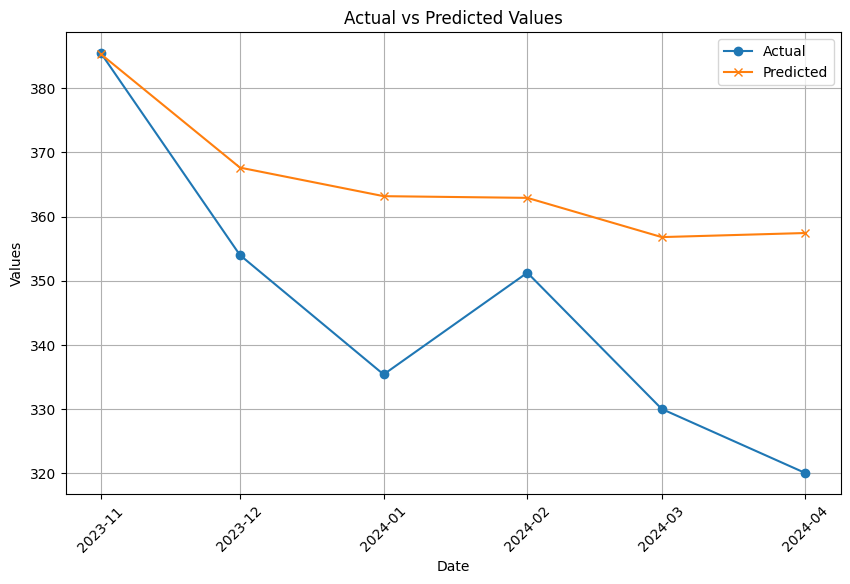

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Modeling - Best Quality

## Define Predictor

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=n_test,
    path="autogluon",
    target="target",
    eval_metric="MASE",
)

## Fit Predictor

In [ ]:
predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=600,
    num_val_windows=3
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          8
GPU Count:          0
Memory Avail:       47.64 GB / 50.99 GB (93.4%)
Disk Space Avail:   183.52 GB / 225.83 GB (81.3%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 360 rows, 1 time series. Med

## Predict

In [ ]:
predictions = predictor.predict(train_data)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id    timestamp                                                    
urea_price 2023-11-01  385.334921  310.044520  337.657598  355.827777   
           2023-12-01  367.640506  262.190878  299.341826  323.868054   
           2024-01-01  363.184072  234.910582  280.918742  311.679682   
           2024-02-01  362.919308  217.352911  268.277599  304.281720   
           2024-03-01  356.801668  197.180142  253.658924  292.500654   
           2024-04-01  357.438520  185.318959  246.055885  287.952080   

                              0.4         0.5         0.6         0.7  \
item_id    timestamp                                                    
urea_price 2023-11-01  370.766593  385.334921  399.827289  414.899438   
           2023-12-01  347.267361  367.640506  388.395066  409.961846   
           2024-01-01  337.866028  363.184072  387.901106  414.494522   
           2024-02-01  333.937982  362.919308  392.393159  422.544370   
           2024-03-01  325.610012  356.801668  388.263425  421.324702   
           2024-04-01  323.645659  357.438520  390.966128  426.452635   

                              0.8         0.9  
item_id    timestamp                           
urea_price 2023-11-01  432.843355  464.075177  
           2023-12-01  434.679994  475.017565  
           2024-01-01  445.681725  492.208225  
           2024-02-01  457.313743  509.605053  
           2024-03-01  459.727039  516.923756  
           2024-04-01  468.015902  529.806117

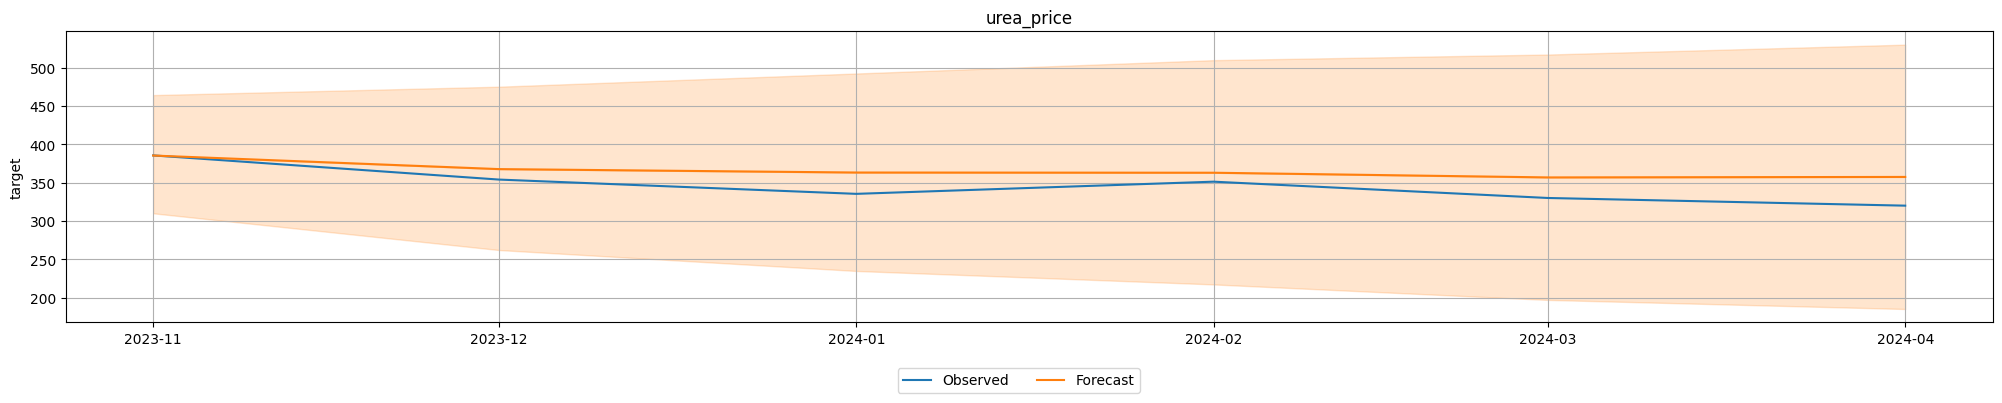

In [ ]:
# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=300, max_num_item_ids=1);

## Compare

In [ ]:
actual = test_data[target_col].values
pred = predictions['mean'].values.flatten()

In [ ]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index.get_level_values('timestamp')
comparison_df

,Actual,Predicted
timestamp,,
2023-11-01,385.50,385.334921
2023-12-01,354.00,367.640506
2024-01-01,335.38,363.184072
2024-02-01,351.25,362.919308
2024-03-01,330.00,356.801668
2024-04-01,320.00,357.438520


## Evaluate

In [ ]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.058883
RMSE,23.149161
MAE,19.586526
R2,-0.192357


## Recap

In [ ]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Preset'] = 'best_quality'
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Preset,MAPE,RMSE,MAE,R2
0,fast_training,0.086531,33.529756,29.734957,-1.501477
1,medium_quality,0.086531,33.529756,29.734957,-1.501477
2,high_quality,0.058883,23.149161,19.586526,-0.192357
3,best_quality,0.058883,23.149161,19.586526,-0.192357


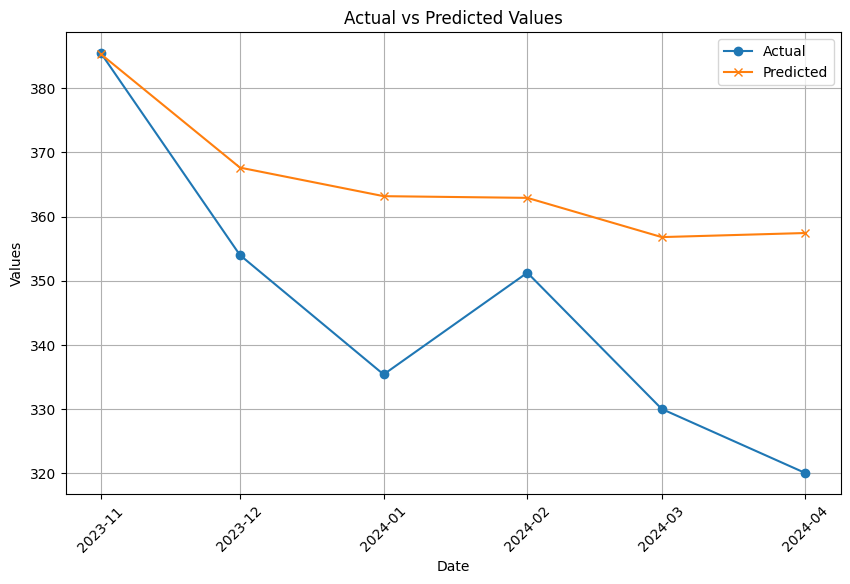

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()